In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from math import ceil
#from tqdm.notebook import tqdm

from train_test import train, test

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset

In [2]:
VAL_SIZE = 0.1
BATCH_SIZE = 64

# download the training and testing datasets
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./root',
                                          train=False,
                                          transform=transforms.ToTensor(),
                                          download=True)

# split the training set into train and validation sets
train_indices, val_indices, _, _ = train_test_split(range(len(train_dataset)),
                                                    train_dataset.targets,
                                                    stratify=train_dataset.targets,
                                                    test_size=VAL_SIZE)

train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)

# now create the batches of the train, val, test sets
train_loader = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_split, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

844
94
157


torch.Size([28, 28])


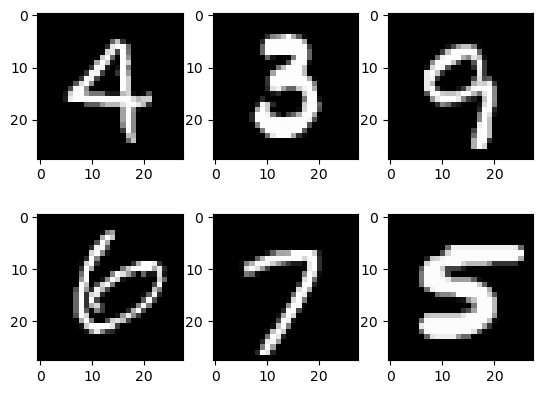

In [3]:
# show some samples from test set

samples = iter(test_loader)
sample_data, sample_targets = next(samples)
print((sample_data[0][0]).size())

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_data[i][0], cmap='gray')
plt.show()

## Model

We build 4 main blocks:
- Convolutional blocks (conv+batchnorm+siLU)
- Inverted residual block (which uses the depthwise separable convolution)
- Squeeze and excitation technique (SE): 
    - SE Technique works similar to the self-attention mechanism for network channels
    - It provides a different weight for each channel
- Stochastic Depth: a subset of layers is randomly dropped and bypass them with the identity function. And a full network is used during testing/inference

In [4]:
# Convolutional Block

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, groups=1, bn=True, act=True):
        super(ConvBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                              groups=groups, bias=False)
        self.conv_bn = nn.BatchNorm2d(out_channels) if bn else nn.Identity()
        self.silu = nn.SiLU() if act else nn.Identity()
        
    def forward(self, x):
        x = self.silu(self.conv_bn(self.conv(x)))
            
        return x

In [5]:
# Squeeze and Excitation Block

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, kernel_size=1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, kernel_size=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        y = self.se(x)
        
        return x * y

In [6]:
# Stochastic Depth Module

class StochasticDepth(nn.Module):
    def __init__(self, survival_prob = 0.8):
        super(StochasticDepth, self).__init__()
        
        self.p = survival_prob
        
    def forward(self, x):
        
        # if not in training mode not drop layers
        if not self.training:
            return x
        
        # create a random tensor which decide what layers have to turn off
        binary_tensor = torch.rand(x.shape[0], 1, 1, 1, device=x.device) < self.p
        
        return torch.div(x, self.p) * binary_tensor

In [7]:
# Inverted Residual Block

class MBConvBlock(nn.Module):
    
    # reduction: SE Block, expansion_factor: how much expand the inverted residual block
    def __init__(self, in_channels, out_channels, kernel_size=3,
                 stride=1, expansion_factor=6, reduction=4, survival_prob=0.8):
        super(MBConvBlock, self).__init__()
        
        self.skip_connection = (stride == 1 and in_channels == out_channels)
        intermediate_channels = int(in_channels * expansion_factor)
        padding = (kernel_size - 1) // 2
        reduced_dim = int(in_channels // reduction)
        
        self.expand = nn.Identity() if (expansion_factor == 1) else ConvBlock(in_channels, intermediate_channels, kernel_size=1)
        self.depthwise_conv = ConvBlock(intermediate_channels, intermediate_channels,
                                        kernel_size=kernel_size, stride=stride,
                                        padding=padding, groups=intermediate_channels)
        self.se = SqueezeExcitation(intermediate_channels, reduced_dim=reduced_dim)
        self.pointwise_conv = ConvBlock(intermediate_channels, out_channels,
                                        kernel_size=1, act=False)
        self.drop_layers = StochasticDepth(survival_prob=survival_prob)
        
    def forward(self, x):
        residual = x
        
        x = self.expand(x)
        x = self.depthwise_conv(x)
        x = self.se(x)
        x = self.pointwise_conv(x)
        
        if self.skip_connection:
            x = self.drop_layers(x)
            x += residual
        
        return x

In [8]:
# EfficientNet 

class EfficientNet(nn.Module):
    def __init__(self, width_factor=1, depth_factor=1, dropout_rate=0.2, num_classes=10):
        super(EfficientNet, self).__init__()
        
        last_channel = ceil(128 * width_factor)
        self.features = self._feature_extractor(width_factor, depth_factor, last_channel)
        self.adaptAvgPool = nn.AdaptiveAvgPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(last_channel, num_classes)
            )
    
    def forward(self, x):
        x = self.features(x)
        x = self.adaptAvgPool(x)
        x = x.reshape(x.shape[0], -1) # flatten the out in a single vector
        x = self.fc(x)
        
        return x
    
    def _feature_extractor(self, width_factor, depth_factor, last_channel):
        
        channels = 4*ceil(int(16*width_factor) / 4)
        layers = [ConvBlock(1, channels, kernel_size=3, stride=2, padding=1)]
        in_channels = channels
        
        # these are hyper-parameters
        # parametes used in well-known efficientNet
        """
        kernels = [3, 3, 5, 3, 5, 5, 3]
        expansions = [1, 6, 6, 6, 6, 6, 6]
        num_channels = [16, 24, 40, 80, 112, 192, 320]
        num_layers = [1, 2, 2, 3, 3, 4, 1]
        strides = [1, 2, 2, 2, 1, 2, 1]
        """
        # personal for this specific problem
        
        kernels = [3, 3, 3, 3]
        expansions = [1, 4, 4, 4]
        num_channels = [8, 16, 24, 32]
        num_layers = [1, 2, 2, 3]
        strides = [1, 2, 2, 2]
        
        # scale channels and num_layers according to width and depth factors
        scaled_num_channels = [4*ceil(int(c * width_factor) / 4) for c in num_channels]
        scaled_num_layers = [int(d * depth_factor) for d in num_layers]
        
        for i in range(len(scaled_num_channels)):
            layers += [MBConvBlock(in_channels if repeat == 0 else scaled_num_channels[i],
                                   scaled_num_channels[i],
                                   kernel_size=kernels[i],
                                   stride=strides[i] if repeat == 0 else 1,
                                   expansion_factor=expansions[i]
                                  )
                      for repeat in range(scaled_num_layers[i])
                      ]
            in_channels = scaled_num_channels[i]
            
        layers.append(ConvBlock(in_channels, last_channel, kernel_size=1, stride=1, padding=0))
        
        return nn.Sequential(*layers)

In [9]:
# well-known efficient configuration
"""
efficient_net_config = {
    # tuple of width factor, depth factor, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 224, 0.2),
    "b1" : (1.0, 1.1, 240, 0.2),
    "b2" : (1.1, 1.2, 260, 0.3),
    "b3" : (1.2, 1.4, 300, 0.3),
    "b4" : (1.4, 1.8, 380, 0.4),
    "b5" : (1.6, 2.2, 456, 0.4),
    "b6" : (1.8, 2.6, 528, 0.5),
    "b7" : (2.0, 3.1, 600, 0.5)
}
"""

# for this specific problem 
efficient_net_config = {
    # tuple of width factor, depth factor, resolution, and Survival Prob
    "b0" : (1.0, 1.0, 28, 0.2),
    "b1" : (1.0, 1.1, 28, 0.2),
    "b2" : (1.1, 1.2, 28, 0.3)
}

In [10]:
version = 'b0' # choose the desired version
width_factor, depth_factor, res, dropout_rate = efficient_net_config[version]
model = EfficientNet(width_factor=width_factor, depth_factor=depth_factor, dropout_rate=dropout_rate, num_classes=10).to(device)
summary(model, input_size=(BATCH_SIZE, 1, 28, 28))

Layer (type:depth-idx)                             Output Shape              Param #
EfficientNet                                       [64, 10]                  --
├─Sequential: 1-1                                  [64, 128, 2, 2]           --
│    └─ConvBlock: 2-1                              [64, 16, 14, 14]          --
│    │    └─Conv2d: 3-1                            [64, 16, 14, 14]          144
│    │    └─BatchNorm2d: 3-2                       [64, 16, 14, 14]          32
│    │    └─SiLU: 3-3                              [64, 16, 14, 14]          --
│    └─MBConvBlock: 2-2                            [64, 8, 14, 14]           --
│    │    └─Identity: 3-4                          [64, 16, 14, 14]          --
│    │    └─ConvBlock: 3-5                         [64, 16, 14, 14]          176
│    │    └─SqueezeExcitation: 3-6                 [64, 16, 14, 14]          148
│    │    └─ConvBlock: 3-7                         [64, 8, 14, 14]           144
│    └─MBConvBlock: 2-3        

## Training and Validation the Model

In [11]:
# loss and optmizer
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
EPOCHS = 5 #100

for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion)
    print('\n')
    val_epoch_loss, val_epoch_acc = test(model, val_loader, criterion)
    
    print('\n')
    print(f"training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}%")
    print(f"validation loss: {val_epoch_loss:.3f}, validation acc: {val_epoch_acc:.3f}%")
    print('-'*50)

[INFO]: Epoch 1 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 2.280, training acc: 14.961%
validation loss: 2.217, validation acc: 25.483%
--------------------------------------------------
[INFO]: Epoch 2 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 2.153, training acc: 26.628%
validation loss: 2.054, validation acc: 37.367%
--------------------------------------------------
[INFO]: Epoch 3 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.968, training acc: 37.680%
validation loss: 1.835, validation acc: 48.950%
--------------------------------------------------
[INFO]: Epoch 4 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.746, training acc: 47.731%
validation loss: 1.523, validation acc: 58.583%
--------------------------------------------------
[INFO]: Epoch 5 of 5
Training


  0%|          | 0/844 [00:00<?, ?it/s]



Validation


  0%|          | 0/94 [00:00<?, ?it/s]



training loss: 1.519, training acc: 56.446%
validation loss: 1.301, validation acc: 66.150%
--------------------------------------------------


In [13]:
"""
# save the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion,
            }, './model.pth')
""";